# GAN face generator

In [1]:
# Bringing in tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
# Bringing in matplotlib for viz stuff
from matplotlib import pyplot as plt

# Do some data transformation
import numpy as np

# Manage folders and directories
import os

# 1. Dataset 

In [3]:
DATA_PATH = os.path.join('data_extend','train')
ds = tf.keras.utils.image_dataset_from_directory(DATA_PATH)

Found 28816 files belonging to 7 classes.


## 1.1 Understand dataset elements

(256, 256, 3)


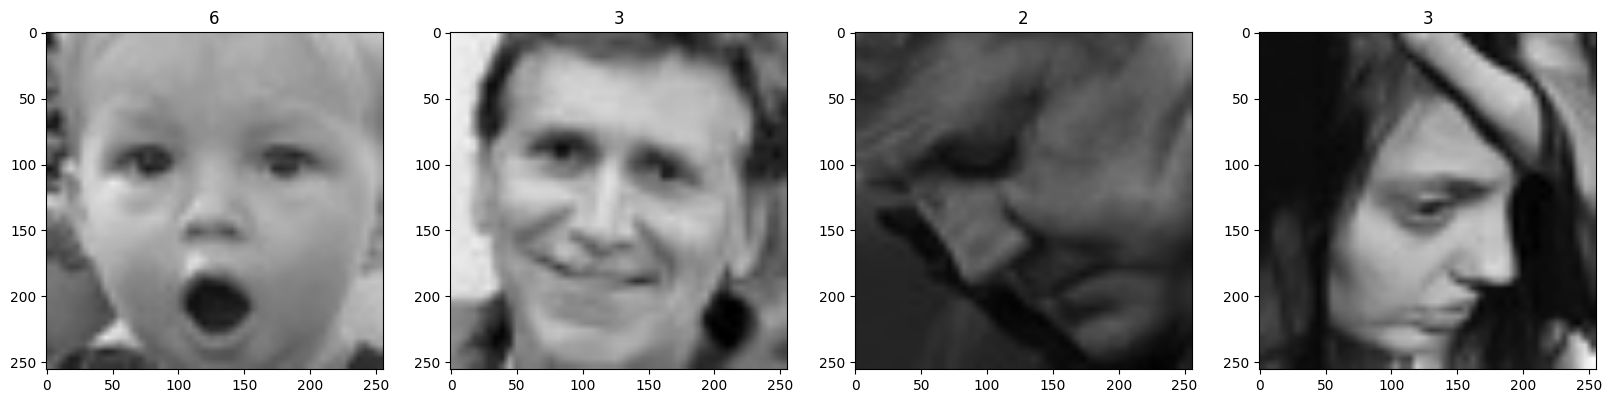

In [4]:
data_iterator = ds.as_numpy_iterator() 
fig, axs = plt.subplots(ncols=4, figsize=(20,20))

for ax in axs:
    img = data_iterator.next()[0][0]
    ax.imshow(img.astype(int))
    ax.title.set_text(data_iterator.next()[1][0])

print(data_iterator.next()[0][0].shape)

## 1.2 preprocess the dataset

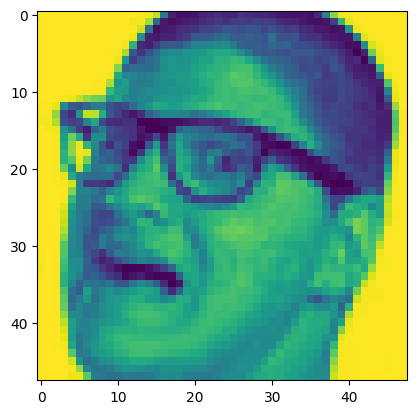

(48, 48, 1)


In [5]:
# Scale and return images only 
def preprocess_images(x,y): 
    image = tf.image.resize(x,(48,48))
    image = tf.image.rgb_to_grayscale(image)
    image = image/255
    return image

img = data_iterator.next()[0][0]
lab = data_iterator.next()[1][0]
img = preprocess_images(img,lab)

plt.figure()
plt.imshow(img)
plt.show()
print(img.shape)

In [6]:
# Reload the dataset 
ds = tf.keras.utils.image_dataset_from_directory(DATA_PATH).unbatch()
# Running the dataset through the scale_images preprocessing step
ds = ds.map(preprocess_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

Found 28816 files belonging to 7 classes.


In [7]:
ds.as_numpy_iterator().next().shape

(128, 48, 48, 1)

# 2. Build Generator and Discriminator 

In [8]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [9]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 12x12x128
    # Beginnings of a generated image
    model.add(Dense(12*12*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((12,12,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [10]:
generator = build_generator()

In [11]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 0s 14ms/step


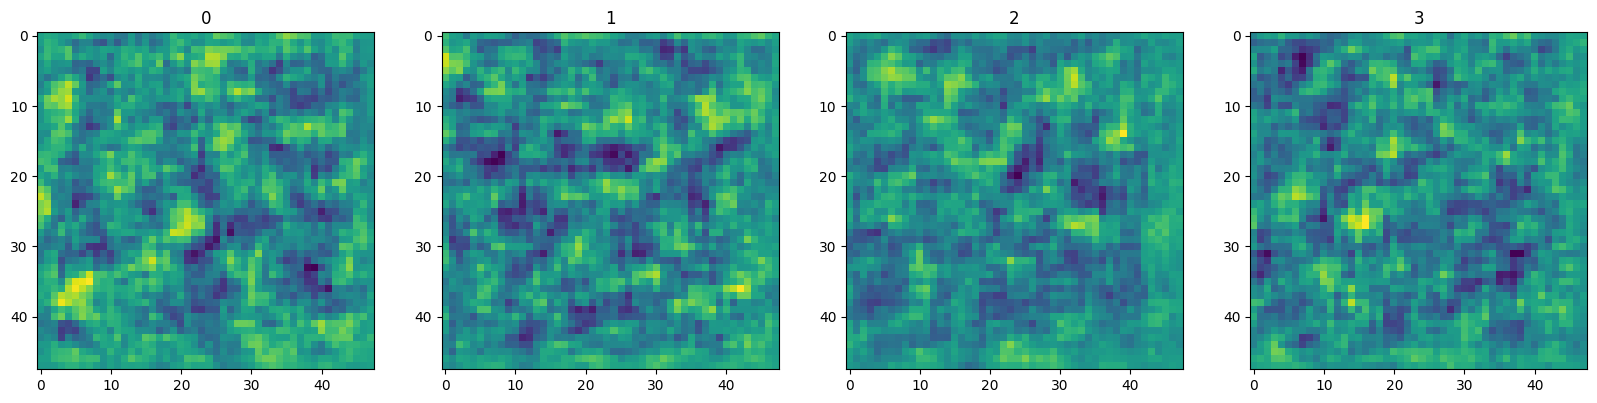

In [12]:
# Generate inputs
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

In [13]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (48,48,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [14]:
discriminator = build_discriminator()

In [15]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy

In [16]:
from tensorflow.keras.models import load_model
generator = load_model(os.path.join('models','face_generator.h5'))
discriminator = load_model(os.path.join('models','face_discriminator.h5'))

In [17]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.000001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

# 3. TRAINING LOOP

In [18]:
# Importing the base model class to subclass our training step 
from tensorflow.keras.models import Model

In [19]:
class FaceGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [20]:
# Create instance of subclassed model
facegan = FaceGAN(generator, discriminator)

In [21]:
# Compile the model
facegan.compile(g_opt, d_opt, g_loss, d_loss)

In [22]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [23]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('generated_items', f'generated_img_{epoch}_{i}.png'))

Epoch 1/100
      6/Unknown - 10s 293ms/step - d_loss: 0.6998 - g_loss: 0.6206WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1096s vs `on_train_batch_end` time: 0.1529s). Check your callbacks.
226/226 [==============================] - 76s 297ms/step - d_loss: 0.6968 - g_loss: 0.6473
Epoch 2/100
226/226 [==============================] - 67s 297ms/step - d_loss: 0.6944 - g_loss: 0.6631
Epoch 3/100
226/226 [==============================] - 70s 308ms/step - d_loss: 0.6960 - g_loss: 0.6596
Epoch 4/100
226/226 [==============================] - 76s 338ms/step - d_loss: 0.6955 - g_loss: 0.6679
Epoch 5/100
226/226 [==============================] - 101s 448ms/step - d_loss: 0.6957 - g_loss: 0.6678
Epoch 6/100
226/226 [==============================] - 145s 641ms/step - d_loss: 0.6939 - g_loss: 0.6635
Epoch 7/100
226/226 [==============================] - 139s 614ms/step - d_loss: 0.6938 - g_loss: 0.6622
Epoch 8/100
226/226 [========

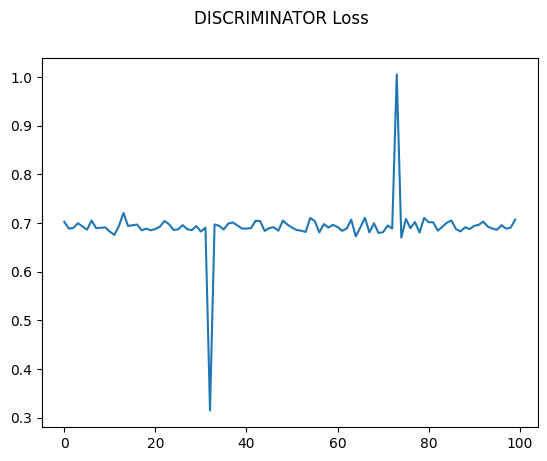

Epoch 1/100
      6/Unknown - 2s 308ms/step - d_loss: 0.6917 - g_loss: 0.6633WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1103s vs `on_train_batch_end` time: 0.1968s). Check your callbacks.
226/226 [==============================] - 70s 308ms/step - d_loss: 0.6933 - g_loss: 0.6709
Epoch 2/100
226/226 [==============================] - 69s 307ms/step - d_loss: 0.6921 - g_loss: 0.6724
Epoch 3/100
226/226 [==============================] - 70s 309ms/step - d_loss: 0.6949 - g_loss: 0.6759
Epoch 4/100
226/226 [==============================] - 67s 299ms/step - d_loss: 0.6938 - g_loss: 0.6666
Epoch 5/100
226/226 [==============================] - 67s 298ms/step - d_loss: 0.6898 - g_loss: 0.6762
Epoch 6/100
226/226 [==============================] - 67s 298ms/step - d_loss: 0.6971 - g_loss: 0.6483
Epoch 7/100
226/226 [==============================] - 68s 299ms/step - d_loss: 0.6943 - g_loss: 0.6577
Epoch 8/100
226/226 [============

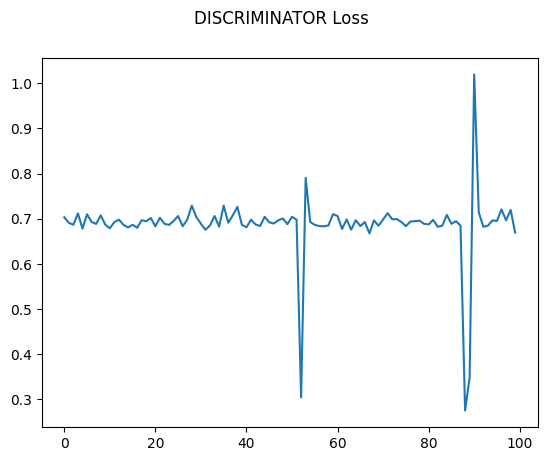

Epoch 1/100
      6/Unknown - 2s 310ms/step - d_loss: 0.6742 - g_loss: 0.6474WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1115s vs `on_train_batch_end` time: 0.1976s). Check your callbacks.
226/226 [==============================] - 70s 310ms/step - d_loss: 0.6922 - g_loss: 0.6515
Epoch 2/100
226/226 [==============================] - 70s 309ms/step - d_loss: 0.6983 - g_loss: 0.6582
Epoch 3/100
226/226 [==============================] - 70s 309ms/step - d_loss: 0.6944 - g_loss: 0.6552
Epoch 4/100
226/226 [==============================] - 70s 310ms/step - d_loss: 0.6957 - g_loss: 0.6664
Epoch 5/100
226/226 [==============================] - 70s 310ms/step - d_loss: 0.6931 - g_loss: 0.6637
Epoch 6/100
226/226 [==============================] - 70s 309ms/step - d_loss: 0.6944 - g_loss: 0.6593
Epoch 7/100
226/226 [==============================] - 70s 310ms/step - d_loss: 0.6941 - g_loss: 0.6644
Epoch 8/100
226/226 [============

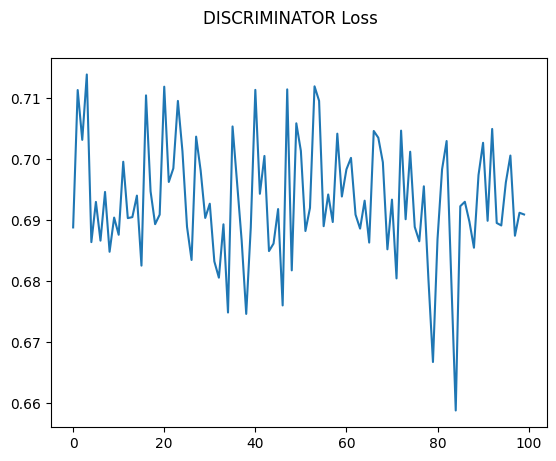

Epoch 1/100
      6/Unknown - 2s 299ms/step - d_loss: 0.6908 - g_loss: 0.6807WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1072s vs `on_train_batch_end` time: 0.1910s). Check your callbacks.
226/226 [==============================] - 67s 298ms/step - d_loss: 0.6916 - g_loss: 0.6787
Epoch 2/100
226/226 [==============================] - 67s 298ms/step - d_loss: 0.6951 - g_loss: 0.6708
Epoch 3/100
226/226 [==============================] - 67s 298ms/step - d_loss: 0.6942 - g_loss: 0.6675
Epoch 4/100
226/226 [==============================] - 67s 298ms/step - d_loss: 0.6946 - g_loss: 0.6691
Epoch 5/100
226/226 [==============================] - 67s 298ms/step - d_loss: 0.6929 - g_loss: 0.6746
Epoch 6/100
226/226 [==============================] - 67s 298ms/step - d_loss: 0.6931 - g_loss: 0.6607
Epoch 7/100
226/226 [==============================] - 67s 298ms/step - d_loss: 0.6933 - g_loss: 0.6637
Epoch 8/100
226/226 [============

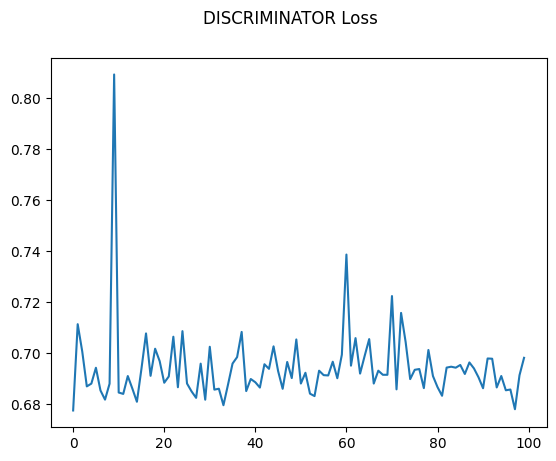

Epoch 1/100
      6/Unknown - 2s 298ms/step - d_loss: 0.6930 - g_loss: 0.6742WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1070s vs `on_train_batch_end` time: 0.1906s). Check your callbacks.
226/226 [==============================] - 67s 298ms/step - d_loss: 0.6937 - g_loss: 0.6771
Epoch 2/100
226/226 [==============================] - 67s 298ms/step - d_loss: 0.6918 - g_loss: 0.6794
Epoch 3/100
226/226 [==============================] - 67s 298ms/step - d_loss: 0.6969 - g_loss: 0.6730
Epoch 4/100
226/226 [==============================] - 67s 298ms/step - d_loss: 0.6934 - g_loss: 0.6817
Epoch 5/100
226/226 [==============================] - 67s 298ms/step - d_loss: 0.6935 - g_loss: 0.6767
Epoch 6/100
226/226 [==============================] - 67s 298ms/step - d_loss: 0.6841 - g_loss: 0.6784
Epoch 7/100
226/226 [==============================] - 67s 298ms/step - d_loss: 0.6941 - g_loss: 0.6553
Epoch 8/100
226/226 [============

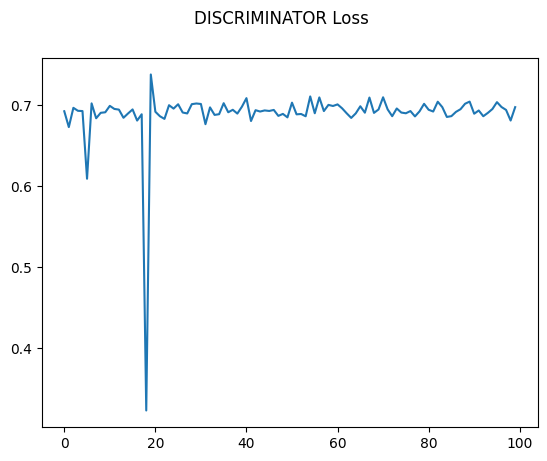

Epoch 1/100
      6/Unknown - 2s 300ms/step - d_loss: 0.6938 - g_loss: 0.6773WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1081s vs `on_train_batch_end` time: 0.1916s). Check your callbacks.
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6942 - g_loss: 0.6781
Epoch 2/100
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6941 - g_loss: 0.6847
Epoch 3/100
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6938 - g_loss: 0.6814
Epoch 4/100
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6936 - g_loss: 0.6803
Epoch 5/100
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6934 - g_loss: 0.6821
Epoch 6/100
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6937 - g_loss: 0.6808
Epoch 7/100
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6927 - g_loss: 0.6726
Epoch 8/100
226/226 [============

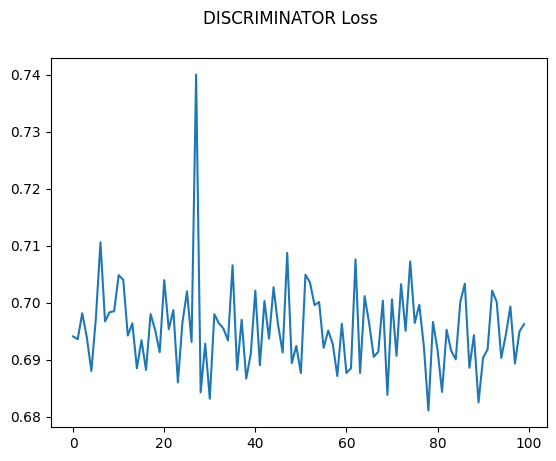

Epoch 1/100
      6/Unknown - 2s 300ms/step - d_loss: 0.6932 - g_loss: 0.6859WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1079s vs `on_train_batch_end` time: 0.1915s). Check your callbacks.
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6920 - g_loss: 0.6862
Epoch 2/100
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6952 - g_loss: 0.6796
Epoch 3/100
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6935 - g_loss: 0.6803
Epoch 4/100
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6940 - g_loss: 0.6708
Epoch 5/100
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6944 - g_loss: 0.6749
Epoch 6/100
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6941 - g_loss: 0.6792
Epoch 7/100
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6825 - g_loss: 0.6926
Epoch 8/100
226/226 [============

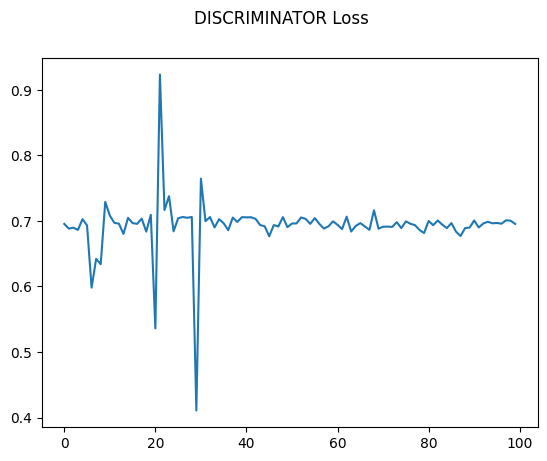

Epoch 1/100
      6/Unknown - 2s 300ms/step - d_loss: 0.6967 - g_loss: 0.6722WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1080s vs `on_train_batch_end` time: 0.1914s). Check your callbacks.
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6940 - g_loss: 0.6724
Epoch 2/100
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6943 - g_loss: 0.6729
Epoch 3/100
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6931 - g_loss: 0.6775
Epoch 4/100
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6935 - g_loss: 0.6781
Epoch 5/100
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6933 - g_loss: 0.6751
Epoch 6/100
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6938 - g_loss: 0.6730
Epoch 7/100
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6911 - g_loss: 0.6752
Epoch 8/100
226/226 [============

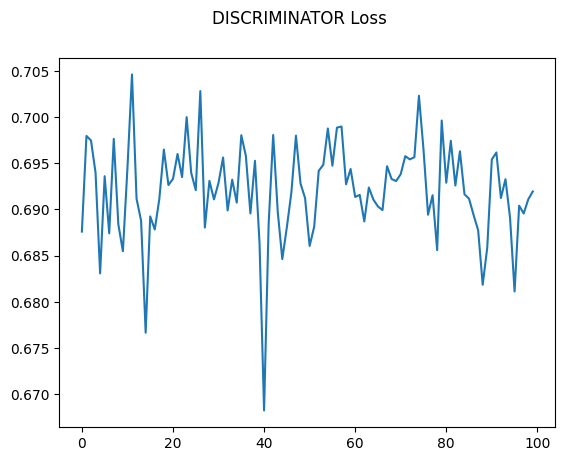

Epoch 1/100
      6/Unknown - 2s 310ms/step - d_loss: 0.6944 - g_loss: 0.6800WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1113s vs `on_train_batch_end` time: 0.1983s). Check your callbacks.
226/226 [==============================] - 70s 309ms/step - d_loss: 0.6933 - g_loss: 0.6806
Epoch 2/100
226/226 [==============================] - 70s 308ms/step - d_loss: 0.6937 - g_loss: 0.6783
Epoch 3/100
226/226 [==============================] - 70s 308ms/step - d_loss: 0.6937 - g_loss: 0.6864
Epoch 4/100
226/226 [==============================] - 70s 309ms/step - d_loss: 0.6930 - g_loss: 0.6843
Epoch 5/100
226/226 [==============================] - 70s 308ms/step - d_loss: 0.6935 - g_loss: 0.6823
Epoch 6/100
226/226 [==============================] - 70s 308ms/step - d_loss: 0.6934 - g_loss: 0.6767
Epoch 7/100
226/226 [==============================] - 70s 308ms/step - d_loss: 0.6946 - g_loss: 0.6762
Epoch 8/100
226/226 [============

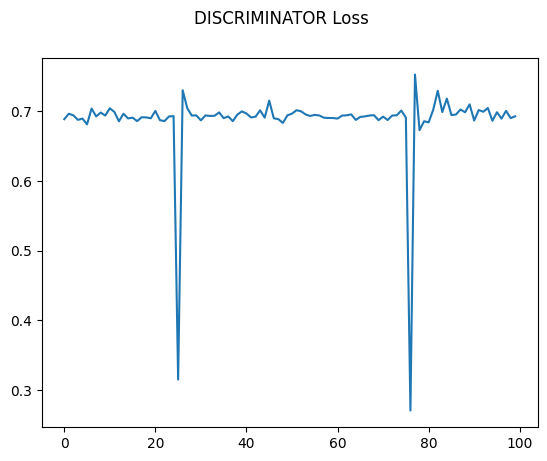

Epoch 1/100
      6/Unknown - 2s 300ms/step - d_loss: 0.6954 - g_loss: 0.6858WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1081s vs `on_train_batch_end` time: 0.1911s). Check your callbacks.
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6948 - g_loss: 0.6884
Epoch 2/100
226/226 [==============================] - 68s 299ms/step - d_loss: 0.6942 - g_loss: 0.6869
Epoch 3/100
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6935 - g_loss: 0.6889
Epoch 4/100
226/226 [==============================] - 68s 301ms/step - d_loss: 0.6945 - g_loss: 0.6892
Epoch 5/100
226/226 [==============================] - 68s 301ms/step - d_loss: 0.6940 - g_loss: 0.6910
Epoch 6/100
226/226 [==============================] - 68s 301ms/step - d_loss: 0.6934 - g_loss: 0.6964
Epoch 7/100
226/226 [==============================] - 68s 301ms/step - d_loss: 0.6924 - g_loss: 0.7018
Epoch 8/100
226/226 [============

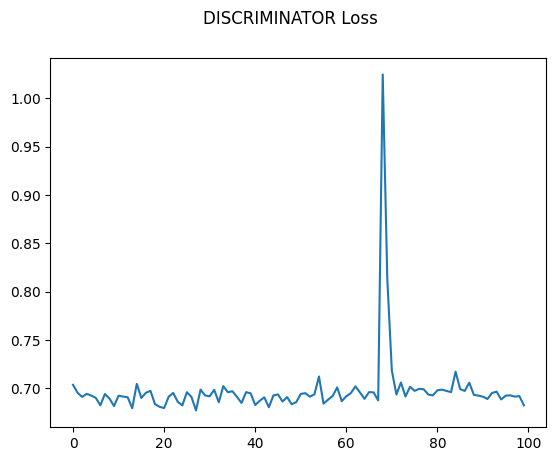

Epoch 1/100
      6/Unknown - 2s 308ms/step - d_loss: 0.6926 - g_loss: 0.6853WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1112s vs `on_train_batch_end` time: 0.1965s). Check your callbacks.
226/226 [==============================] - 70s 308ms/step - d_loss: 0.6951 - g_loss: 0.6859
Epoch 2/100
226/226 [==============================] - 70s 308ms/step - d_loss: 0.6956 - g_loss: 0.6886
Epoch 3/100
226/226 [==============================] - 69s 308ms/step - d_loss: 0.6937 - g_loss: 0.6907
Epoch 4/100
226/226 [==============================] - 70s 308ms/step - d_loss: 0.6939 - g_loss: 0.6895
Epoch 5/100
226/226 [==============================] - 70s 310ms/step - d_loss: 0.6928 - g_loss: 0.6965
Epoch 6/100
226/226 [==============================] - 70s 309ms/step - d_loss: 0.6945 - g_loss: 0.6864
Epoch 7/100
226/226 [==============================] - 70s 308ms/step - d_loss: 0.6937 - g_loss: 0.6983
Epoch 8/100
226/226 [============

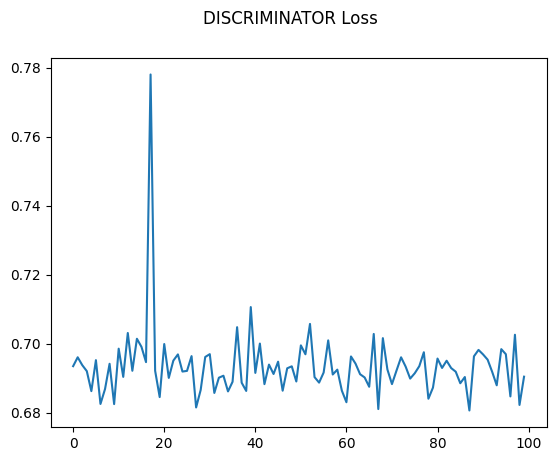

Epoch 1/100
      6/Unknown - 4s 773ms/step - d_loss: 0.6917 - g_loss: 0.6840WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2623s vs `on_train_batch_end` time: 0.4852s). Check your callbacks.
226/226 [==============================] - 147s 650ms/step - d_loss: 0.6939 - g_loss: 0.6805
Epoch 2/100
226/226 [==============================] - 158s 700ms/step - d_loss: 0.6937 - g_loss: 0.6834
Epoch 3/100
226/226 [==============================] - 135s 596ms/step - d_loss: 0.6932 - g_loss: 0.6827
Epoch 4/100
226/226 [==============================] - 72s 317ms/step - d_loss: 0.6936 - g_loss: 0.6801
Epoch 5/100
226/226 [==============================] - 145s 642ms/step - d_loss: 0.6938 - g_loss: 0.6827
Epoch 6/100
226/226 [==============================] - 141s 623ms/step - d_loss: 0.6935 - g_loss: 0.6867
Epoch 7/100
226/226 [==============================] - 149s 658ms/step - d_loss: 0.6927 - g_loss: 0.6839
Epoch 8/100
226/226 [======

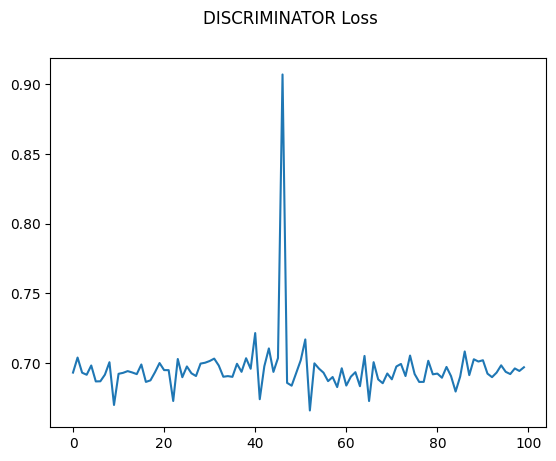

Epoch 1/100
      6/Unknown - 2s 301ms/step - d_loss: 0.6913 - g_loss: 0.6707WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1087s vs `on_train_batch_end` time: 0.1916s). Check your callbacks.
226/226 [==============================] - 68s 301ms/step - d_loss: 0.6945 - g_loss: 0.6734
Epoch 2/100
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6942 - g_loss: 0.6782
Epoch 3/100
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6937 - g_loss: 0.6845
Epoch 4/100
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6934 - g_loss: 0.6802
Epoch 5/100
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6931 - g_loss: 0.6825
Epoch 6/100
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6935 - g_loss: 0.6787
Epoch 7/100
226/226 [==============================] - 68s 300ms/step - d_loss: 0.6944 - g_loss: 0.6805
Epoch 8/100
226/226 [============

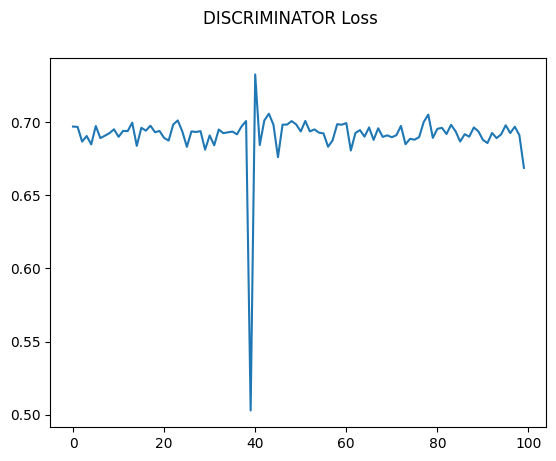

Epoch 1/100
      6/Unknown - 2s 301ms/step - d_loss: 0.6784 - g_loss: 0.7136WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1091s vs `on_train_batch_end` time: 0.1923s). Check your callbacks.
226/226 [==============================] - 68s 301ms/step - d_loss: 0.6789 - g_loss: 0.6879
Epoch 2/100
226/226 [==============================] - 68s 301ms/step - d_loss: 0.6997 - g_loss: 0.6559
Epoch 3/100
226/226 [==============================] - 68s 301ms/step - d_loss: 0.6965 - g_loss: 0.6687
Epoch 4/100
226/226 [==============================] - 68s 301ms/step - d_loss: 0.6933 - g_loss: 0.6823
Epoch 5/100
226/226 [==============================] - 68s 301ms/step - d_loss: 0.6927 - g_loss: 0.6874
Epoch 6/100
226/226 [==============================] - 68s 301ms/step - d_loss: 0.6934 - g_loss: 0.6874
Epoch 7/100
226/226 [==============================] - 68s 301ms/step - d_loss: 0.6938 - g_loss: 0.6911
Epoch 8/100
226/226 [============

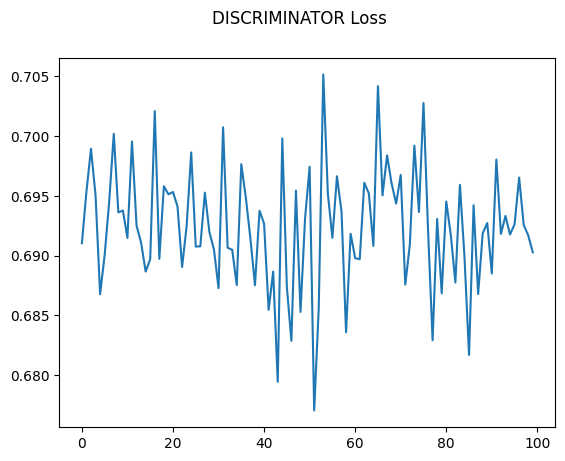

Epoch 1/100
      6/Unknown - 2s 308ms/step - d_loss: 0.6937 - g_loss: 0.6828WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1110s vs `on_train_batch_end` time: 0.1969s). Check your callbacks.
     66/Unknown - 20s 309ms/step - d_loss: 0.6939 - g_loss: 0.6823

KeyboardInterrupt: 

In [24]:
from tensorflow.keras.models import load_model

# Recommend 2000 epochs
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.000001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()


generator = load_model(os.path.join('models','face_generator.h5'))
discriminator = load_model(os.path.join('models','face_discriminator.h5'))

facegan = FaceGAN(generator, discriminator)
facegan.compile(g_opt, d_opt, g_loss, d_loss)
for i in range(20):
    hist = facegan.fit(ds, epochs=100, callbacks=[ModelMonitor()])
    generator.save('face_generator.h5')
    discriminator.save('face_discriminator.h5')
    plt.figure()
    plt.suptitle('Loss')
    plt.plot(hist.history['d_loss'], label='d_loss')
    plt.plot(hist.history['g_loss'], label='g_loss')
    plt.legend()
    plt.show()

In [ ]:
generator.save('face_generator.h5')
discriminator.save('face_discriminator.h5')

NameError: name 'generator' is not defined

In [ ]:
plt.figure()
plt.suptitle('DISCRIMINATOR Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.show()

plt.figure()
plt.suptitle('GENERATOR Loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.show()

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))

for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])
plt.style.use('dark_background')
plt.show()